In [320]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [321]:
import tqdm

In [322]:
import functools

In [323]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

import lal
import lalsimulation as lalsim

from scrinet.interfaces import lalutils

In [324]:
from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate
from scrinet.fits import nn

In [325]:
import schwimmbad

In [7]:
# import tensorflow as tf
# num_threads = 1
# tf.config.threading.set_inter_op_parallelism_threads(
#     num_threads
# )

# Data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [326]:
class SinglePool(object):
    """
    from pycbc/pool.py
    used for when n_cores = 1
    """
    def broadcast(self, fcn, args):
        return self.map(fcn, [args])

    def map(self, f, items):
        return [f(a) for a in items]

In [9]:
def worker_wfgen(task, new_times, M, deltaT, f_min, approximant, inclination, t_min, t_max, npts, chi):
    q = task
        
    new_times = np.linspace(t_min, t_max, npts)
    
    m1, m2 = phenom.m1_m2_M_q(M, q)
    pp = dict(m1=m1, m2=m2, deltaT=deltaT,
              f_min=f_min,
              inclination=inclination,
              S1z=chi, S2z=chi,
              approximant=approximant
             )
    p = lalutils.gen_td_wf_params(**pp)
    t, amp, phase = lalutils.gen_td_wf(p, t_min=t_min, t_max=t_max)

    iamp = IUS(t, amp)
    iphase = IUS(t, phase)

    amp = iamp(new_times)
    phase = iphase(new_times)
    freq = IUS(new_times, phase).derivative()(new_times)

    tshift = lalutils.peak_align_shift(new_times, amp)
    amp = lalutils.peak_align_interp(new_times, amp, tshift)
    phase = lalutils.peak_align_interp(new_times, phase, tshift)
    freq = lalutils.peak_align_interp(new_times, freq, tshift)

    
    return amp, phase, freq

In [10]:
def gen_1d_massratio_data(q_array, M, n_cores, deltaT=1/1024., f_min=10,
                              approximant=lalsim.SEOBNRv4_opt, inclination=0,
                              t_min=-10000, t_max=100, npts=5000, chi=0
                         ):

    new_times = np.linspace(t_min, t_max, npts)
    
    worker_wfgen_partial = functools.partial(worker_wfgen,
                                             new_times=new_times,
                                             M=M,
                                             deltaT=deltaT,
                                             f_min=f_min,
                                             approximant=approximant,
                                             inclination=inclination,
                                             t_min=t_min,
                                             t_max=t_max,
                                             npts=npts,
                                             chi=chi
                                            )
    
    data = []
    coords = []
    
#     tasks = list(zip(q_array, chi_array))
    tasks = list(q_array)
    
    if n_cores == 1:
        pool = SinglePool()
    else:
        pool = schwimmbad.choose_pool(mpi=False, processes=n_cores)
    results = pool.map(worker_wfgen_partial, tasks)    
    try:
        pool.close
    except AttributeError:
        pass
    
    for i in range(len(q_array)):
        q = q_array[i]
        amp = results[i][0]
        phase = results[i][1]
        freq = results[i][2]
        
        d = {"t":new_times, "amp":amp, "phase":phase, "freq": freq}
        
        data.append(d)
        coords.append([q])
    
    n_t_points = len(new_times)
    n_waveforms = len(data)
    ts_amp = np.zeros(shape=(n_waveforms, n_t_points))
    ts_phase = np.zeros(shape=(n_waveforms, n_t_points))
    ts_freq = np.zeros(shape=(n_waveforms, n_t_points))
    
    for i in range(n_waveforms):
        ts_amp[i] = data[i]['amp'] / phenom.eta_from_q(coords[i][0]) / 1e5
        ts_phase[i] = data[i]['phase'] - data[i]['phase'][0]
        ts_freq[i] = data[i]['freq']
        
    return new_times, ts_amp, ts_phase, ts_freq, np.array(coords)

In [11]:
%%time
new_times, ts_amp, ts_phase, ts_freq, coords = gen_1d_massratio_data(
    np.linspace(1, 3, 10),
    M=60,
    n_cores=3
)

CPU times: user 2.57 ms, sys: 31.4 ms, total: 34 ms
Wall time: 582 ms


# condensed code

In [12]:
def build_surrogate(
    amp_or_phase,
    qmin=1,
    qmax=10,
    qnpts=1000,
    mtotal=100,
    nvalidation_points=1000,
    greedy_tol=1e-6,
    fit_method='lr',
    scaleX=False,
    scaleY=False,
    epochs=500,
    n_cores=1,
    maxdegs=4,
    fit_verbose=False,
    basis_method='eim'
):
    """
    qnpts: initial number of points to check seed basis
    nvalidation_points: number of points to validate the model
    
    
    iterate_surrogate_error=True
        if True then will iterate using surrogate error in a second greedy step
        if False then will set max_iter to 1 so that it doesn't iterate
    max_iter:
        max_iter for surrogate iteration greedy step
    sur_model_error_tol:
        error tolerance for 2nd greedy step
    """
    seed_x, seed_ts_amp, seed_ts_phase, seed_ts_freq, seed_ts_coords = gen_1d_massratio_data(
        np.linspace(qmin, qmax, 3),
        mtotal,
        n_cores=n_cores
    )
    # Make integration rule

    int_range = [seed_x[0], seed_x[-1]]
    int_num = len(seed_x)

    integration = greedyrb.Riemann(int_range, num=int_num)
    x = integration.nodes  # Define x for convenience
    
    sur = surrogate.Surrogate(integration, basis_method=basis_method, output_dir=amp_or_phase)
    
    if amp_or_phase == "amp":
        seed_ts = seed_ts_amp
    elif amp_or_phase == "phase":
        seed_ts = seed_ts_phase
        
    sur.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)
    
    # check seed basis and add points
    _, ts_amp, ts_phase, ts_freq, ts_coords = gen_1d_massratio_data(
        np.random.uniform(qmin, qmax, qnpts),
        mtotal,
        n_cores=n_cores)
    
    if amp_or_phase == "amp":
        ts = ts_amp
    elif amp_or_phase == "phase":
        ts = ts_phase
    

    sur.run_greedy_sweep(ts, ts_coords, verbose=True, greedy_tol=greedy_tol)

    # build eim
    # eim needs to be built from training_set at the greedy points
    _, ts_amp, ts_phase, _, _ = gen_1d_massratio_data(
        sur.grb.greedy_points.ravel(),
        mtotal,
        n_cores=n_cores)
    if amp_or_phase == "amp":
        ts = ts_amp
    elif amp_or_phase == "phase":
        ts = ts_phase 
    sur.build_eim(ts)

    # fit_eim
    X = sur.grb.greedy_points.copy()
    ndim = X.shape[1]
    if fit_method in ['lr', 'gpr', 'nn']:
        X[:,0] = np.log(X[:,0])
        
    if basis_method == 'eim':
        y = sur.grb.eim.data.T
        
    _, ts_amp, ts_phase, _, ext_ts_coords = gen_1d_massratio_data(
        np.random.uniform(qmin, qmax, nvalidation_points),
        mtotal,
        n_cores=n_cores
    )

    if amp_or_phase == "amp":
        ext_ts = ts_amp
    elif amp_or_phase == "phase":
        ext_ts = ts_phase
        
    ext_alpha = sur.compute_projection_coefficients(ext_ts) 

    Xnew = ext_ts_coords.copy()
    Xnew[:,0] = np.log(Xnew[:,0])
    
    Xfit = np.row_stack((X, Xnew))
    yfit = np.row_stack((y, ext_alpha))
    
    # compute validation points
    # check seed basis and add points
    _, vts_amp, vts_phase, _, vts_coords = gen_1d_massratio_data(
        np.random.uniform(qmin, qmax, nvalidation_points),
        mtotal,
        n_cores=n_cores
    )

    if amp_or_phase == "amp":
        vts = vts_amp
    elif amp_or_phase == "phase":
        vts = vts_phase

    alpha_val = sur.compute_projection_coefficients(vts)
    
    Xval = vts_coords.copy()
    Xval[:,0] = np.log(Xval[:,0])

    validation_data=(Xval, alpha_val)

    sur.fit_eim(Xfit, yfit.T, method=fit_method, maxdegs=[maxdegs,maxdegs], max_deg_total=maxdegs*ndim, epochs=epochs, scaleX=scaleX, scaleY=scaleY, validation_data=validation_data)

    model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
    worst_error = model_errors[worst_error_index]
    print(f"worst error = {worst_error}")
    print(f"worst case = {worst_case}")

    plt.figure()
    plt.scatter(vts_coords, model_errors)
    plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
    plt.show()
    plt.close()

    return x, sur

In [285]:
mtotal=60
qmin=1
qmax=4

building seed basis
tolerance reached. exiting

====
training NN
====



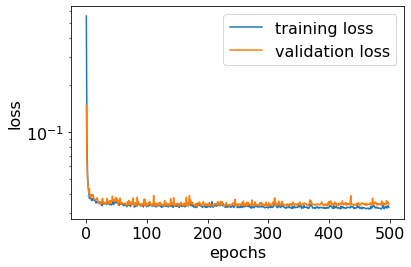

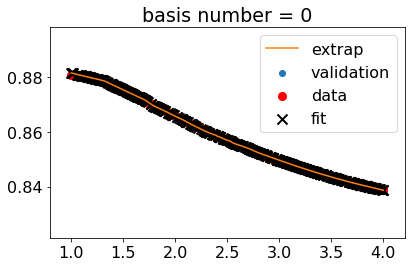

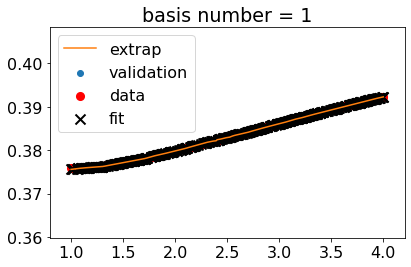

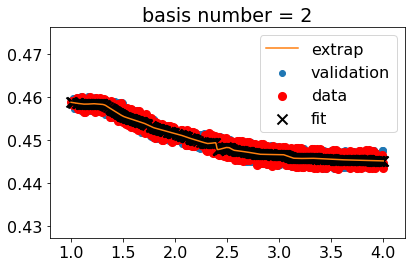

worst error = 0.001032175315774859
worst case = [3.33510287]


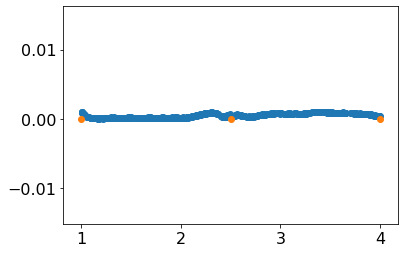

In [286]:
amp_x, amp_sur = build_surrogate(
    amp_or_phase="amp",
    qmin=qmin,
    qmax=qmax,
    qnpts=20,
    mtotal=mtotal,
    nvalidation_points=500,
    greedy_tol=1e-3,
    fit_method='nn',
    scaleX=True,
    scaleY=True,
    n_cores=20,
    maxdegs=4,
    fit_verbose=True,
    basis_method='eim'
)

building seed basis
step = 0, error = 0.15278905964698755
step = 1, error = 0.0031090207615730547
step = 2, error = 0.0004967402173158014
step = 3, error = 5.7483176555420774e-05
step = 4, error = 1.3800823689030514e-06
step = 5, error = 1.279022496113414e-06
tolerance reached. exiting

====
training NN
====



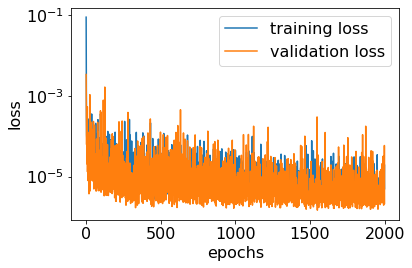

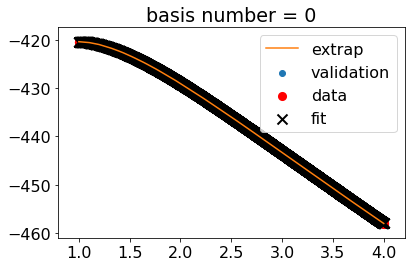

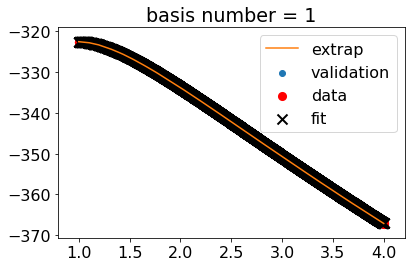

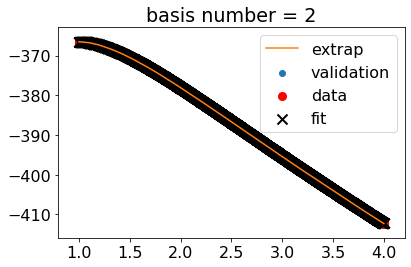

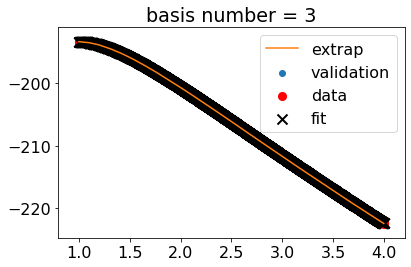

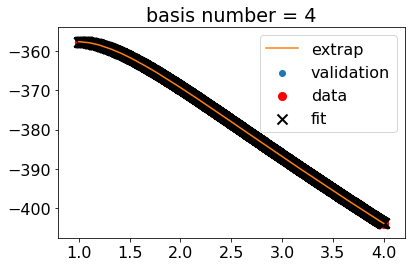

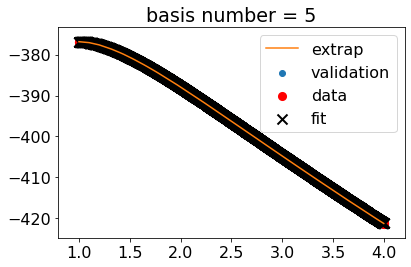

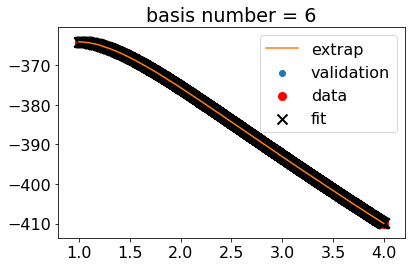

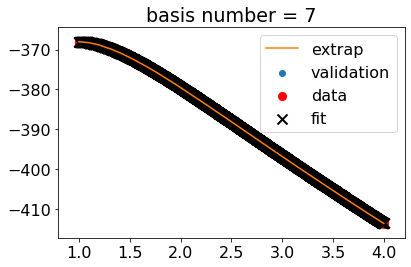

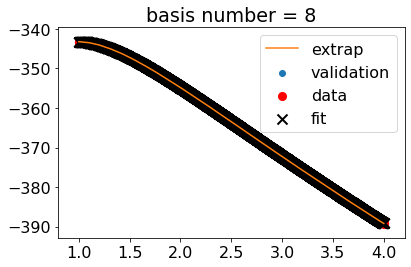

worst error = 8.053435765611685
worst case = [1.00019866]


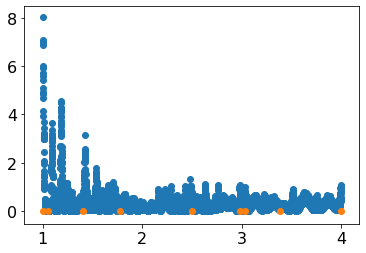

In [287]:
phase_x, phase_sur = build_surrogate(
    amp_or_phase="phase",
    qmin=qmin,
    qmax=qmax,
    qnpts=10,
    mtotal=mtotal,
    nvalidation_points=5000,
    greedy_tol=1e-6,
    fit_method='nn',
    scaleX=True,
    scaleY=True,
    n_cores=30,
    maxdegs=4,
    fit_verbose=True,
    basis_method='eim',
    epochs=2000
)

In [ ]:
%%timeit
amp_sur.predict([[1]])

In [ ]:
%%timeit
phase_sur.predict([[1]])

In [288]:
def wave_sur(q, amp_sur=amp_sur, phase_sur=phase_sur):
    
    amp = amp_sur.predict([[q]])
    phase = phase_sur.predict([[q]])
    h = amp * np.exp(-1.j * phase)
    
    return np.real(h), np.imag(h), amp, phase

In [289]:
vs_x, vs_amp, vs_phase, _, vt_coords = gen_1d_massratio_data([1.5], mtotal, n_cores=1)
vs_h = vs_amp[0] * np.exp(-1.j * vs_phase[0])
vs_hp = np.real(vs_h)
vs_hc = np.imag(vs_h)

In [290]:
sur_hp, sur_hc, samp, sphase = wave_sur(1.5)

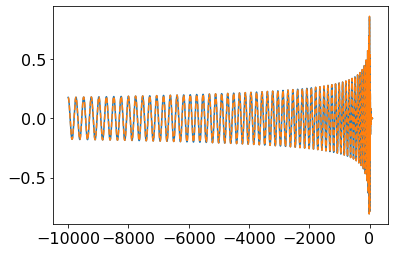

In [291]:
plt.figure()
plt.plot(vs_x, vs_hp)
plt.plot(vs_x, sur_hp, ls='--')

(-300, 100)

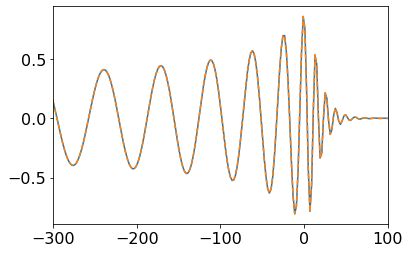

In [292]:
plt.figure()
plt.plot(vs_x, vs_hp)
plt.plot(vs_x, sur_hp, ls='--')
plt.xlim(-300,100)

In [293]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [ ]:
%%timeit
gen_1d_massratio_data([2], mtotal, n_cores=1)

In [ ]:
%%timeit
wave_sur(2)

In [294]:
qq = 1.

vs_x, vs_amp, vs_phase, vs_freq, vt_coords = gen_1d_massratio_data([qq], mtotal, n_cores=1)
vs_h = vs_amp[0] * np.exp(-1.j * vs_phase[0])
vs_hp = np.real(vs_h)
vs_hc = np.imag(vs_h)

sur_hp, sur_hc, samp, sphase = wave_sur(qq)

maxmatch = np.max(np.abs(match(vs_hp, sur_hp, vs_x)))

print(maxmatch)

0.9993583603299843


In [317]:
def worker_match(q):
    q = np.float(q)
    vs_x, vs_amp, vs_phase, vs_freq, vt_coords = gen_1d_massratio_data([q], mtotal, n_cores=1)
    vs_h = vs_amp[0] * np.exp(-1.j * vs_phase[0])
    vs_hp = np.real(vs_h)
    vs_hc = np.imag(vs_h)
    
    sur_hp, sur_hc, samp, sphase = wave_sur(q)
    
    maxmatch = np.max(np.abs(match(vs_hp, sur_hp, vs_x)))
    
    return maxmatch

In [319]:
worker_match(2)

0.9999918673588514

In [297]:
matches = np.array([worker_match(qq) for qq in phase_sur.grb.greedy_points[:,0] ])

In [298]:
print('worst missmatch: {:.5e}'.format(np.max(1-matches)))
print('best missmatch : {:.5e}'.format(np.min(1-matches)))

worst missmatch: 6.41640e-04
best missmatch : 1.11718e-05


(1e-09, 0.11220184543019636)

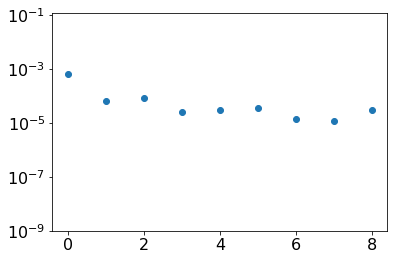

In [299]:
plt.figure()
plt.scatter(range(len(matches)), 1-matches)
plt.yscale('log')
plt.ylim(1e-9)

In [ ]:
qs = np.linspace(qmin, qmax, 1000)
matches = np.zeros(len(qs))
for i in tqdm.tqdm(range(len(qs))):
    q = qs[i]
#     print(f"working q = {q}")
    vs_x, vs_amp, vs_phase, _, vt_coords = gen_1d_massratio_data([q], mtotal, n_cores=1)
    vs_h = vs_amp[0] * np.exp(-1.j * vs_phase[0])
    vs_hp = np.real(vs_h)
    vs_hc = np.imag(vs_h)
    
    sur_hp, sur_hc, samp, sphase = wave_sur(q)
    
    maxmatch = np.max(np.abs(match(vs_hp, sur_hp, vs_x)))
    
    matches[i] = maxmatch

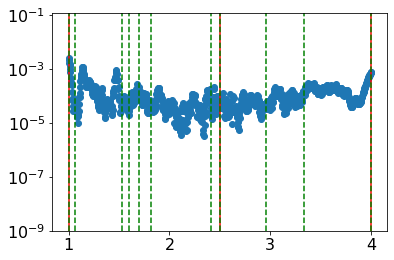

In [314]:
plt.figure()
plt.scatter(qs, 1-matches)
plt.yscale('log')
plt.ylim(1e-9)
for gp in amp_sur.grb.greedy_points:
    plt.axvline(gp, c='r')
for gp in phase_sur.grb.greedy_points:
    plt.axvline(gp, c='g', ls='--')

# save and load models

In [300]:
# save amp model
amp_sur.save_basis("amp_basis")
amp_sur.fits[0].save_X_scalers("amp/X_scalers")
amp_sur.fits[0].save_Y_scalers("amp/Y_scalers")

In [301]:
# save phase model
phase_sur.save_basis("phase_basis")
phase_sur.fits[0].save_X_scalers("phase/X_scalers")
phase_sur.fits[0].save_Y_scalers("phase/Y_scalers")

In [327]:
def load_amp_model():
    model = nn.RegressionANN()
    model.load_model("amp/best.h5")
    model.load_X_scalers("amp/X_scalers.npy")
    model.load_Y_scalers("amp/Y_scalers.npy")
    model.scaleX = True
    model.scaleY = True
    
    basis = np.load("amp/amp_basis.npy")
    
    return model, basis

In [328]:
def load_phase_model():
    model = nn.RegressionANN()
    model.load_model("phase/best.h5")
    model.load_X_scalers("phase/X_scalers.npy")
    model.load_Y_scalers("phase/Y_scalers.npy")
    model.scaleX = True
    model.scaleY = True
    
    basis = np.load("phase/phase_basis.npy")
    
    return model, basis

In [329]:
amp_model, amp_basis = load_amp_model()

In [330]:
phase_model, phase_basis = load_phase_model()

# predict multiple

In [331]:
def wave_sur_many(q):
    
    q = np.log(q).reshape(-1,1)
    
    amp_model, amp_basis = load_amp_model()
    amp_alpha = amp_model.predict(q)
    amp = np.dot(amp_alpha, amp_basis)
    
    phase_model, phase_basis = load_phase_model()
    phase_alpha = phase_model.predict(q)
    phase = np.dot(phase_alpha, phase_basis)
    
    h = amp * np.exp(-1.j * phase)
    
    return np.real(h), np.imag(h), amp, phase

In [332]:
qs = np.linspace(qmin, qmax, 1000)

In [333]:
%%time
sur_hp, sur_hc, samp, sphase = wave_sur_many(qs)

CPU times: user 1.21 s, sys: 596 ms, total: 1.81 s
Wall time: 1.5 s


In [334]:
%%time
n_cores=20
vs_x, vs_amp, vs_phase, _, vt_coords = gen_1d_massratio_data(qs, mtotal, n_cores=n_cores)

CPU times: user 385 ms, sys: 3.57 s, total: 3.96 s
Wall time: 8.87 s


In [335]:
matches = np.zeros(len(qs))
for i in tqdm.tqdm(range(len(qs))):
    q = qs[i]
    vs_h = vs_amp[i] * np.exp(-1.j * vs_phase[i])
    vs_hp = np.real(vs_h)
    vs_hc = np.imag(vs_h)
    
    maxmatch = np.max(np.abs(match(vs_hp, sur_hp[i], vs_x)))

    matches[i] = maxmatch

100%|██████████| 1000/1000 [00:01<00:00, 517.78it/s]


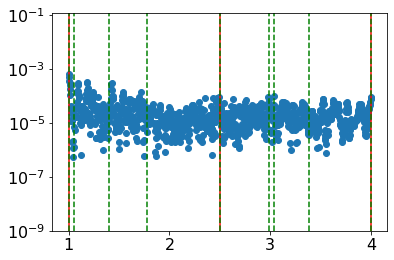

In [336]:
plt.figure()
plt.scatter(qs, 1-matches)
plt.yscale('log')
plt.ylim(1e-9)
for gp in amp_sur.grb.greedy_points:
    plt.axvline(gp, c='r')
for gp in phase_sur.grb.greedy_points:
    plt.axvline(gp, c='g', ls='--')